# MS035 Preprocess
Created: 01/29/2024 \
Updated: 04/07/2024

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy


import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/LFPAnalysis/')

In [4]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [5]:
# Specify root directory for un-archived data and results 
base_dir = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir = f'{base_dir}ephys_analysis/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'

subj_id = 'MS035'
subj_format = ['edf']
subj_site = ['MSSM']


# Make mne_data


### Load and resample data


In [6]:
edf_files = glob(f'{neural_dir}{subj_id}/raw/*.edf')

mne_data = mne.io.read_raw_edf(edf_files[0], preload=True)


Extracting EDF parameters from /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS035/raw/MS035_SWB.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3394047  =      0.000 ...  3314.499 secs...


In [7]:
mne_data

<RawEDF | MS035_SWB.edf, 276 x 3394048 (3314.5 s), ~6.98 GB, data loaded>

In [8]:
# mne_data.ch_names

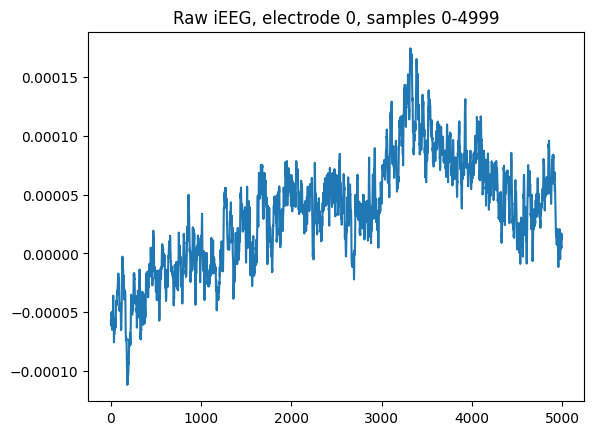

In [8]:
# Sanity check one channel data

plt.plot(mne_data._data[0,:4999])
plt.title("Raw iEEG, electrode 0, samples 0-4999")
plt.show()

### Resampling data 

In [9]:
#resampling if patient is not sampled at 512
resample_sr = 500
mne_data.resample(sfreq=resample_sr, npad='auto', n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 276 out of 276 | elapsed:   38.0s finished


<RawEDF | MS035_SWB.edf, 276 x 1657250 (3314.5 s), ~3.41 GB, data loaded>

### Photodiode
- examine photodiode 

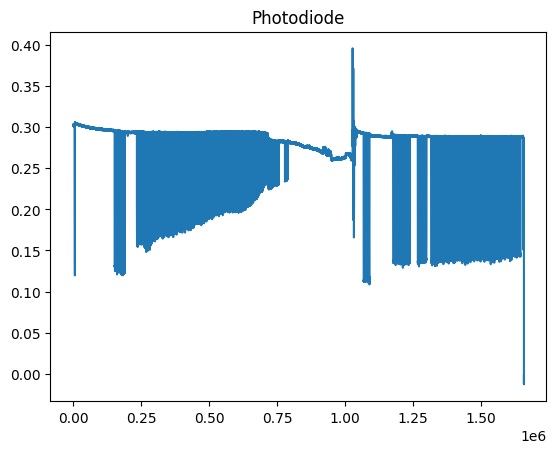

In [10]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index("DC1")
plt.plot(mne_data._data[trig_ix])
plt.title("Photodiode")
plt.show()

In [11]:
mne_data.save(f'{neural_dir}{subj_id}/photodiode.fif', picks='DC1', overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS035/photodiode.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS035/photodiode.fif
[done]


In [12]:
mne_data.drop_channels(['DC1'])

<RawEDF | MS035_SWB.edf, 275 x 1657250 (3314.5 s), ~3.40 GB, data loaded>

### Notch filter line noise

In [13]:
mne_data.info['line_freq'] = 60
# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 275 out of 275 | elapsed:   16.5s finished


<RawEDF | MS035_SWB.edf, 275 x 1657250 (3314.5 s), ~3.40 GB, data loaded>

### Anatomical Localization

In [14]:
### Rename channels to be lowercase before anatomical localization
new_name_dict = {x:x.replace(" ", "").lower() for x in mne_data.ch_names}
mne_data.rename_channels(new_name_dict)

<RawEDF | MS035_SWB.edf, 275 x 1657250 (3314.5 s), ~3.40 GB, data loaded>

In [15]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,ManualExamination,Notes
0,LaCaS1,A32sg_L,-4.193839,40.722342,-1.249460,-3.409516,28.122622,-4.643328,Gray,Left ACgG anterior cingulate gyrus,Area s24,L ACC,L CG,Left cingulate gyrus C,NaN,NaN
1,LaCaS10,A9/46d_L,-21.368608,57.508612,37.129623,-23.595365,46.014935,36.574161,Gray,Left SFG superior frontal gyrus,Unknown,L Middle Frontal Gyrus,L MFG,Left middle frontal gyrus 3 A,NaN,NaN
2,LaCaS11,A9/46d_L,-23.365674,59.506978,41.127445,-25.838634,48.159044,40.898034,Unknown,Left SFG superior frontal gyrus,Unknown,L Superior Frontal Gyrus,L MFG,Left middle frontal gyrus 3 A,oob,NaN
3,LaCaS12,Unknown,-25.362740,60.705997,45.525048,-28.069497,49.502020,45.723240,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,oob,NaN
4,LaCaS2,A32sg_L,-6.190905,42.321034,2.748361,-5.845285,29.986278,-0.298868,White,Left Cerebral White Matter,Unknown,L Olfactory cortex,L CG,Unknown,WM,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,RmOlF5,A11l_R,19.371542,47.117112,-6.846410,23.356883,34.915942,-10.712708,White,Right MOrG medial orbital gyrus,Area Fo3,R IFG (p Orbitalis),R OrG,Right frontal orbital 4 D,WM,NaN
168,RmOlF6,A11l_R,23.765087,46.717439,-4.047935,28.298187,34.880922,-7.718436,Gray,Right POrG posterior orbital gyrus,Area Fo3,R IFG (p Orbitalis),R OrG,Right frontal orbital 4 D,NaN,NaN
169,RmOlF7,A12/47o_R,27.759220,46.717439,-1.249460,32.784291,35.177035,-4.651516,White,Right Cerebral White Matter,Unknown,R IFG (p Orbitalis),R OrG,Unknown,WM,NaN
170,RmOlF8,A44op_R,31.753352,46.717439,1.948797,37.260470,35.337213,-1.005693,Gray,Right Cerebral White Matter,Unknown,R IFG (p Orbitalis),R IFG,Right anterior pars triangularis B,NaN,NaN


In [16]:
list(elec_locs.label)

['LaCaS1',
 'LaCaS10',
 'LaCaS11',
 'LaCaS12',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LAglT1',
 'LAglT10',
 'LAglT2',
 'LAglT3',
 'LAglT4',
 'LAglT5',
 'LAglT6',
 'LAglT7',
 'LAglT8',
 'LAglT9',
 'LaImM1',
 'LaImM10',
 'LaImM11',
 'LaImM12',
 'LaImM13',
 'LaImM14',
 'LaImM15',
 'LaImM16',
 'LaImM2',
 'LaImM3',
 'LaImM4',
 'LaImM5',
 'LaImM6',
 'LaImM7',
 'LaImM8',
 'LaImM9',
 'LCMiP1',
 'LCMiP10',
 'LCMiP11',
 'LCMiP12',
 'LCMiP13',
 'LCMiP14',
 'LCMiP2',
 'LCMiP3',
 'LCMiP4',
 'LCMiP5',
 'LCMiP6',
 'LCMiP7',
 'LCMiP8',
 'LCMiP9',
 'LHplT1',
 'LHplT10',
 'LHplT11',
 'LHplT12',
 'LHplT2',
 'LHplT3',
 'LHplT4',
 'LHplT5',
 'LHplT6',
 'LHplT7',
 'LHplT8',
 'LHplT9',
 'LmCmS1',
 'LmCmS10',
 'LmCmS2',
 'LmCmS3',
 'LmCmS4',
 'LmCmS5',
 'LmCmS6',
 'LmCmS7',
 'LmCmS8',
 'LmCmS9',
 'LmOlF1',
 'LmOlF10',
 'LmOlF11',
 'LmOlF12',
 'LmOlF2',
 'LmOlF3',
 'LmOlF4',
 'LmOlF5',
 'LmOlF6',
 'LmOlF7',
 'LmOlF8',
 'LmOlF9',
 'RaCaS1',
 'RaCaS10',
 'RaCaS1

In [17]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

['lmoif1', 'lmoif2', 'lmoif3', 'lmoif4', 'lmoif5', 'lmoif6', 'lmoif7', 'lmoif8', 'lmoif9', 'lmoif10', 'lmoif11', 'lmoif12', 'rmoifm1', 'rmoifm2', 'rmoifm3', 'rmoifm4', 'rmoifm5', 'rmoifm6', 'rmoifm7', 'rmoifm8', 'rmoifm9', 'rmoifm10', 'rmoifm11', 'rmoifm12', 'lalmm1', 'lalmm2', 'lalmm3', 'lalmm4', 'lalmm5', 'lalmm6', 'lalmm7', 'lalmm8', 'lalmm9', 'lalmm10', 'lalmm11', 'lalmm12', 'lalmm13', 'lalmm14', 'lalmm15', 'lalmm16', 'ralms1', 'ralms2', 'ralms3', 'ralms4', 'ralms5', 'ralms6', 'ralms7', 'ralms8', 'ralms9', 'ralms10', 'ralms11', 'ralms12', 'ralms13', 'ralms14', 'ralms15', 'ralms16', 'c57', 'c58', 'c59', 'c60', 'c61', 'c62', 'c63', 'c64', 'lagit1', 'lagit2', 'lagit3', 'lagit4', 'lagit5', 'lagit6', 'lagit7', 'lagit8', 'lagit9', 'lagit10', 'ragit1', 'ragit2', 'ragit3', 'ragit4', 'ragit5', 'ragit6', 'ragit7', 'ragit8', 'ragit9', 'ragit10', 'lhpit1', 'lhpit2', 'lhpit3', 'lhpit4', 'lhpit5', 'lhpit6', 'lhpit7', 'lhpit8', 'lhpit9', 'lhpit10', 'lhpit11', 'lhpit12', 'rhpit1', 'rhpit2', 'rhpit

In [18]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)


Number of electrodes in the mne file is greater than the number of electrodes in the localization file


In [19]:
unmatched_seeg #make sure there are no unmatched names


[]

In [20]:
new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}


In [21]:
new_name_dict #make sure this passes the eye test 


{'lmoif1': 'lmolf1',
 'lmoif2': 'lmolf2',
 'lmoif3': 'lmolf3',
 'lmoif4': 'lmolf4',
 'lmoif5': 'lmolf5',
 'lmoif6': 'lmolf6',
 'lmoif7': 'lmolf7',
 'lmoif8': 'lmolf8',
 'lmoif9': 'lmolf9',
 'lmoif10': 'lmolf10',
 'lmoif11': 'lmolf11',
 'lmoif12': 'lmolf12',
 'rmoifm1': 'rmolf1',
 'rmoifm2': 'rmolf2',
 'rmoifm3': 'rmolf3',
 'rmoifm4': 'rmolf4',
 'rmoifm5': 'rmolf5',
 'rmoifm6': 'rmolf6',
 'rmoifm7': 'rmolf7',
 'rmoifm8': 'rmolf8',
 'rmoifm9': 'rmolf9',
 'rmoifm10': 'rmolf10',
 'rmoifm11': 'rmolf11',
 'rmoifm12': 'rmolf12',
 'lalmm1': 'laimm1',
 'lalmm2': 'laimm2',
 'lalmm3': 'laimm3',
 'lalmm4': 'laimm4',
 'lalmm5': 'laimm5',
 'lalmm6': 'laimm6',
 'lalmm7': 'laimm7',
 'lalmm8': 'laimm8',
 'lalmm9': 'laimm9',
 'lalmm10': 'laimm10',
 'lalmm11': 'laimm11',
 'lalmm12': 'laimm12',
 'lalmm13': 'laimm13',
 'lalmm14': 'laimm14',
 'lalmm15': 'laimm15',
 'lalmm16': 'laimm16',
 'ralms1': 'raims1',
 'ralms2': 'raims2',
 'ralms3': 'raims3',
 'ralms4': 'raims4',
 'ralms5': 'raims5',
 'ralms6': 'raims

In [22]:
# Rename the mne data according to the localization data

mne_data.rename_channels(new_name_dict)

<RawEDF | MS035_SWB.edf, 275 x 1657250 (3314.5 s), ~3.40 GB, data loaded>

In [23]:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
print(f'We have a total of {len(left_seeg_names)} left sEEG and {len(right_seeg_names)} right sEEG electrodes')
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')



We have a total of 86 left sEEG and 86 right sEEG electrodes
We have a total of 172 sEEG electrodes


In [24]:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
mne_data.set_channel_types(sEEG_mapping_dict)


<RawEDF | MS035_SWB.edf, 275 x 1657250 (3314.5 s), ~3.40 GB, data loaded>

In [25]:
drop_chans = list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names))
mne_data.drop_channels(drop_chans) #number of chans should = number of seegs 

<RawEDF | MS035_SWB.edf, 172 x 1657250 (3314.5 s), ~2.12 GB, data loaded>

In [26]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawEDF | MS035_SWB.edf, 172 x 1657250 (3314.5 s), ~2.12 GB, data loaded>

## Signal Cleaning 
Methods:
- Use manual bad channel detection for **bipolar** referencing
    - bipolar referencing completely ignores channels labeled as 'bad' so do not remove unless absolutely necessary
    - remove ch if there is massive artifact in a channel not in the rest of probe 
    - if entire probe shows same artifact try to keep
- Remove additional channels as needed
- This process is iterative depending on how TFRs look. 

In [27]:
#this is just for my own personal info and to select how many channels to visualize at a time
ch_names = list(elec_locs.label.str.lower())
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)
# probe_names

In [28]:
probe_ch_counts = {} #need this to select channel number for visualization
for p in probe_names:
    c = ch_names_no_num.count(p)
    probe_ch_counts[p] = c

In [29]:
probe_ch_counts

{'lacas': 12,
 'laglt': 10,
 'laimm': 16,
 'lcmip': 14,
 'lhplt': 12,
 'lmcms': 10,
 'lmolf': 12,
 'racas': 14,
 'raglt': 10,
 'raims': 16,
 'rcmip': 14,
 'rhplt': 10,
 'rmcms': 10,
 'rmolf': 12}

### Compare auto detection result to actual lfp data - if trusted save auto result as mne bads
- often inaccurate - verify that all included channels make sense and all channels that should be included are
- take out any crazy noise, especially if it's only in one channel on probe (won't be cancelled out)

In [30]:
# mne_data.info['bads'] = lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict) #this is likely inaccurate - just use to get an idea 
lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict)

['lacas8',
 'racas13',
 'racas14',
 'rhplt10',
 'rhplt3',
 'rhplt9',
 'rmcms7',
 'rmolf10']

Using matplotlib as 2D backend.


<IPython.core.display.Javascript object>


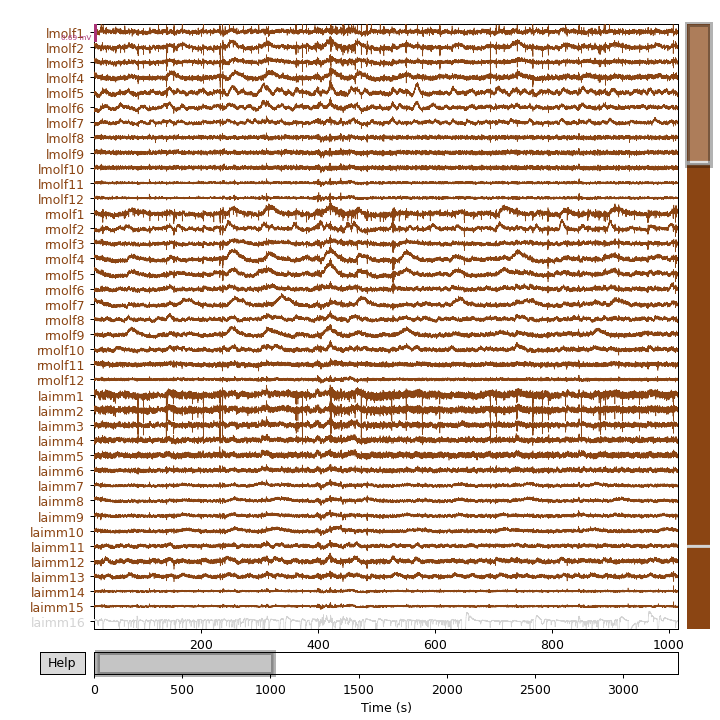

In [31]:
 %matplotlib notebook
fig = mne_data.plot(start=0, duration=1000, n_channels=40, scalings=mne_data._data.max()/30)


In [27]:
mne_data.info['bads'] = ['raglt9', 'laimm16']

# ['laimm16',
#  'lacas12',
#  'raglt9',
#  'laglt10',
#  'rhplt8',
#  'laimm1',
#  'lmolf12',
#  'lmcms3',
#  'laglt1',
#  'raglt1',
#  'raglt2',
#  'rhplt9',
#  'rhplt10',
#  'rhplt1',
#  'racas6',
#  'laglt2',
#  'rmcms4',
#  'lcmip14'] # old 01/2024

In [28]:
mne_data.info #sanity check that bads info saved

<Info | 10 non-empty values
 bads: 2 items (raglt9, laimm16)
 ch_names: lmolf1, lmolf2, lmolf3, lmolf4, lmolf5, lmolf6, lmolf7, lmolf8, ...
 chs: 172 sEEG
 custom_ref_applied: False
 dig: 172 items (172 EEG)
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 250.0 Hz
 meas_date: 2001-01-01 09:51:15 UTC
 nchan: 172
 projs: []
 sfreq: 500.0 Hz
>

# Bipolar Re-referencing 
- plot lfp bp data
- plot psd bp data
- save bp reref data 


In [29]:
#run if only re-ref
anat_file = glob(f'{anat_dir}/{subj_id}_labels.csv')[0]
# mne_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/raw_ieeg.fif', preload=True)

### Bipolar Re-ref

In [30]:
# Re-reference neural data
mne_data_bp_reref = lfp_preprocess_utils.ref_mne(mne_data=mne_data, 
                                              elec_path=anat_file, 
                                              method='bipolar', 
                                              site='MSSM')

sEEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=106, n_times=1657250
    Range : 0 ... 1657249 =      0.000 ...  3314.498 secs
Ready.
Added the following bipolar channels:
lacas1-lacas2, lacas8-lacas9, lacas9-lacas10, laglt1-laglt2, laglt2-laglt3, laglt3-laglt4, laglt4-laglt5, laglt5-laglt6, laglt6-laglt7, laglt7-laglt8, laglt8-laglt9, laglt9-laglt10, laimm1-laimm2, laimm2-laimm3, laimm3-laimm4, laimm4-laimm5, laimm5-laimm6, laimm6-laimm7, laimm8-laimm9, laimm9-laimm10, laimm10-laimm11, laimm11-laimm12, laimm12-laimm13, laimm13-laimm14, lcmip1-lcmip2, lcmip2-lcmip3, lcmip3-lcmip4, lcmip4-lcmip5, lcmip7-lcmip8, lcmip8-lcmip9, lcmip9-lcmip10, lcmip10-lcmip11, lcmip11-lcmip12, lcmip12-lcmip13, lcmip13-lcmip14, lhplt1-lhplt2, lhplt3-lhplt4, lhplt4-lhplt5, lhplt5-lhplt6, lhplt6-lhplt7, lhplt7-lhplt8, lhplt8-lhplt9, lmcms1-lmcms2, lmcms2-lmcms3, lmcms3-lmcms4, lmcms4-lmcms5, lmcms5-lmcms6, lmcms6-lmcms7, lmcms7-lmcms8, lmcms8-lmcms9, lmolf1-lmolf

In [31]:
mne_data_bp_reref

<RawEDF | MS035_SWB.edf, 106 x 1657250 (3314.5 s), ~1.31 GB, data loaded>

In [32]:
mne_data_bp_reref.ch_names

['lacas1-lacas2',
 'lacas8-lacas9',
 'lacas9-lacas10',
 'laglt1-laglt2',
 'laglt2-laglt3',
 'laglt3-laglt4',
 'laglt4-laglt5',
 'laglt5-laglt6',
 'laglt6-laglt7',
 'laglt7-laglt8',
 'laglt8-laglt9',
 'laglt9-laglt10',
 'laimm1-laimm2',
 'laimm2-laimm3',
 'laimm3-laimm4',
 'laimm4-laimm5',
 'laimm5-laimm6',
 'laimm6-laimm7',
 'laimm8-laimm9',
 'laimm9-laimm10',
 'laimm10-laimm11',
 'laimm11-laimm12',
 'laimm12-laimm13',
 'laimm13-laimm14',
 'lcmip1-lcmip2',
 'lcmip2-lcmip3',
 'lcmip3-lcmip4',
 'lcmip4-lcmip5',
 'lcmip7-lcmip8',
 'lcmip8-lcmip9',
 'lcmip9-lcmip10',
 'lcmip10-lcmip11',
 'lcmip11-lcmip12',
 'lcmip12-lcmip13',
 'lcmip13-lcmip14',
 'lhplt1-lhplt2',
 'lhplt3-lhplt4',
 'lhplt4-lhplt5',
 'lhplt5-lhplt6',
 'lhplt6-lhplt7',
 'lhplt7-lhplt8',
 'lhplt8-lhplt9',
 'lmcms1-lmcms2',
 'lmcms2-lmcms3',
 'lmcms3-lmcms4',
 'lmcms4-lmcms5',
 'lmcms5-lmcms6',
 'lmcms6-lmcms7',
 'lmcms7-lmcms8',
 'lmcms8-lmcms9',
 'lmolf1-lmolf2',
 'lmolf4-lmolf5',
 'lmolf5-lmolf6',
 'lmolf6-lmolf7',
 'lmolf7

#### Examine bp ref data 
- examine lfp plot to see if major artifacts are still present
- examine psd to see if there are any major peaks in channels

<IPython.core.display.Javascript object>


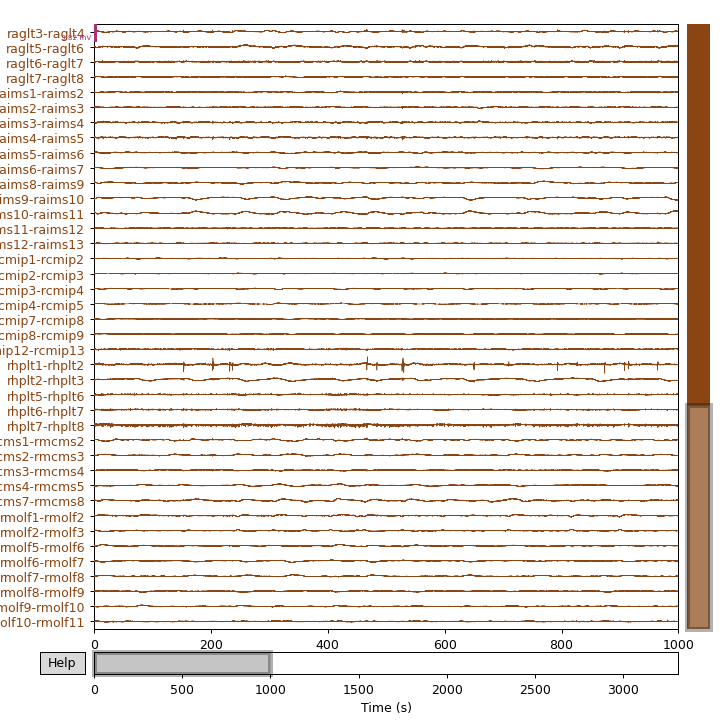

In [39]:
 %matplotlib notebook
fig = mne_data_bp_reref.plot(start=0, duration=1000, n_channels=40, scalings=mne_data_bp_reref._data.max())


Effective window size : 0.512 (s)


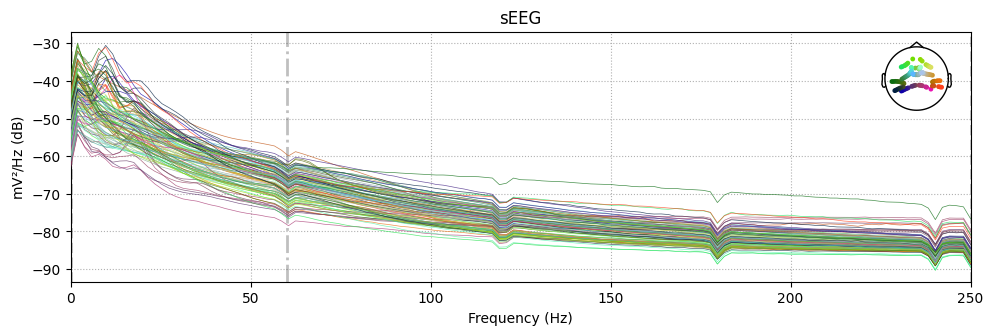

In [33]:
mne_data_bp_reref.compute_psd().plot()

In [34]:
mne_data_bp_reref.save(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS035/bp_ref_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS035/bp_ref_ieeg.fif
[done]


## Save mne_data

In [35]:
mne_data.save(f'{neural_dir}{subj_id}/raw_ieeg.fif',overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS035/raw_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS035/raw_ieeg.fif
[done]


# Epoching + TFRs
- Check whether data is ready to be analyzed - if this step shows noise then steps above should be repeated
- Align photodiode to behavior 
- Epoch data (and mark bad epochs)
- Baseline data
- Visualize TFRs 

In [36]:
#remove mne_data from environment to save memory 
del mne_data, mne_data_bp_reref

### Photodiode Alignment

In [37]:
#load behavior data
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_pt_task_data')
behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
# behav_df = behav_df[behav_df['FeedbackOnset'] != 0] #remove fail trials from behav df
beh_ts = behav_df['TrialOnset'] #timestamp that should be aligned to photodiode 
#load photodiode data
photodiode_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/photodiode.fif', preload=True)

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS035/photodiode.fif...
Isotrak not found
    Range : 0 ... 1657249 =      0.000 ...  3314.498 secs
Ready.
Reading 0 ... 1657249  =      0.000 ...  3314.498 secs...


In [38]:
photodiode_data

<Raw | photodiode.fif, 1 x 1657250 (3314.5 s), ~12.7 MB, data loaded>

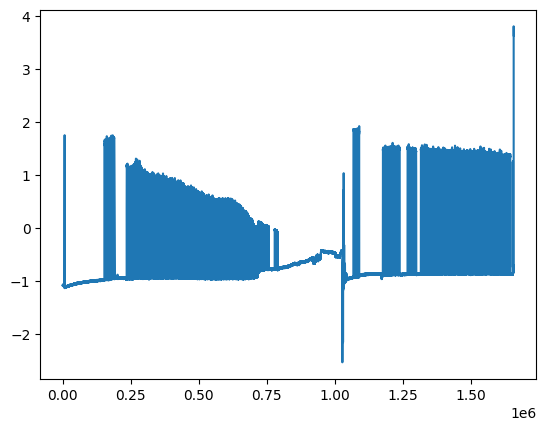

In [41]:
plt.plot(scipy.stats.zscore(-photodiode_data._data[0,:]))
plt.show()

In [42]:
temp_diode = photodiode_data.copy()
temp_data = -temp_diode._data[0,:]
temp_diode._data = temp_data
# temp_data = temp_diode._data[0,:]
# temp_data[0:450000] = 0
# temp_data[570000:] = 0
# temp_data[temp_data>4000] = 0
# temp_data = np.abs(temp_data-np.nanmax(temp_data)) #consider resaving photodiode 
# temp_data = np.abs(temp_diode._data[0, :])
# temp_data[0:1250000] = 0


In [61]:
### Photodiode alignment
smoothSize=11
windSize=15
height=1.1

# Synchronize to the photodiode or whatever your neural sync signal is
slope, offset = sync_utils.synchronize_data(beh_ts, 
                                            temp_diode, #
                                            smoothSize, windSize, height)

7 blocks
.......

found matches for 75 of 119 pulses
5 blocks
.....

found matches for 40 of 119 pulses


In [72]:
print(slope, offset,smoothSize,windSize,height)

0.9999952293415796 14.304587369597812 11 15 1.1


In [71]:
# print(slope, offset,smoothSize,windSize,height) ### old with non resamp photodiode  0.9999929235766264 14.314402112901007 11 15 1.1

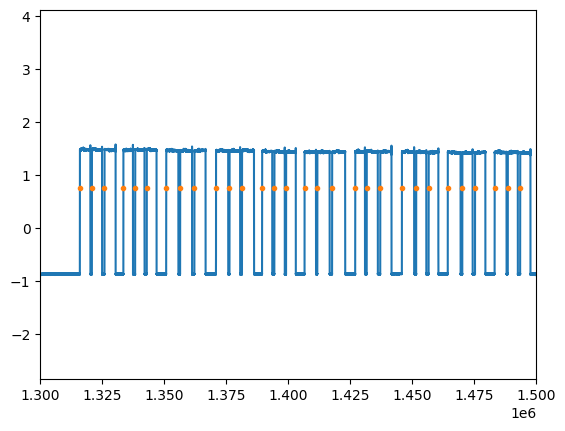

In [69]:
pulses = [(x*slope + offset) for x in beh_ts]
plt.plot(scipy.stats.zscore(temp_diode._data[:]))
# plt.plot(pulses)
plt.plot(np.array(pulses)*500, 
         np.ones_like(np.array(pulses) * photodiode_data.info['sfreq'])-0.25,'.')
# plt.plot(neural_ts*1024, 
#          np.ones_like(neural_ts)-0.25, '.')
plt.xlim([1300000,1500000])
# plt.ylim([5,6])
plt.show()


In [214]:
# del epochs_all_baseline, power_epochs, plot_data

## Epoch Data
- Epoch neural data into trial epochs 
- Add behavioral data to epochs metadata
- Save epochs
- Baseline + decompose data into TFRs
- Plot + save TFRs (examine quality)

### Epoch data

In [73]:
# IED removal requires that we set some parameters for IED detection. 
# 1. peak_thresh: how many stds should they exceed the baseline by? 
# 2. closeness_thresh: how close should they be allowed to be (in sec) to other candidate IEDs? 
# 3. width_thresh: how wide should they have to be (in sec)?

# Defaults:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}

In [74]:
# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'TrialOnset': [-1.0, 0], #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [0, 5.0]} #1 sec decision period + 2 second outcome + 3 second counterfactual

In [75]:
epochs_all_evs = {f'{x}': np.nan for x in evs}

In [76]:
for event in evs.keys():
    # Make the epochs. 
    ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/bp_ref_ieeg.fif', 
                 slope=slope, offset=offset,
                 behav_name=event, behav_times=behav_df[event].values,downsamp_factor=None,
                 ev_start_s=evs[event][0], ev_end_s=evs[event][1], buf_s = 1, IED_args=IED_args) #1.0 buf unsaved

    epochs_all_evs[event] = ev_epochs
    

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS035/bp_ref_ieeg.fif...
    Range : 0 ... 1657249 =      0.000 ...  3314.498 secs
Ready.
Reading 0 ... 1657249  =      0.000 ...  3314.498 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 265 samples (0.530 sec)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 103 out of 106 | elapsed:    7.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 106 out of 106 | elapsed:    7.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 106 out of 106 | elapsed:    8.9s finished


Used Annotations descriptions: ['TrialOnset']
Not setting metadata
152 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 152 events and 1501 original time points ...
0 bad epochs dropped
Adding metadata with 106 columns
Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS035/bp_ref_ieeg.fif...
    Range : 0 ... 1657249 =      0.000 ...  3314.498 secs
Ready.
Reading 0 ... 1657249  =      0.000 ...  3314.498 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 106 out of 106 | elapsed:    5.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 106 out of 106 | elapsed:    8.5s finished


Used Annotations descriptions: ['DecisionOnset']
Not setting metadata
152 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 152 events and 3501 original time points ...
0 bad epochs dropped
Adding metadata with 106 columns


In [77]:
epochs_all_evs 


{'TrialOnset': <Epochs |  152 events (all good), -2 - 1 sec, baseline off, ~184.7 MB, data loaded, with metadata,
  'TrialOnset': 152>,
 'DecisionOnset': <Epochs |  152 events (all good), -1 - 6 sec, baseline off, ~430.5 MB, data loaded, with metadata,
  'DecisionOnset': 152>}

### Add behavioral data to metadata 

In [78]:
behav_params = ['TrialType','SafeBet', 'LowBet', 'HighBet','GambleChoice', 'Outcome',
       'Profit', 'TotalProfit', 'GambleEV', 'CR', 'choiceEV', 'RPE',
       'totalCPE', 'decisionCPE', 'totalRegret', 'decisionRegret',
       'totalRelief', 'decisionRelief', 'totalCF', 'decisionCF', 'pRPE',
       'nRPE']


In [79]:
for event in evs.keys():

    event_metadata = epochs_all_evs[event].metadata.copy()
    
    #independent vars
    for param in behav_params: 
        event_metadata[param] = behav_df[param].tolist()

    epochs_all_evs[event].metadata = event_metadata 
    

Replacing existing metadata with 128 columns
Replacing existing metadata with 128 columns


In [80]:
epochs_all_evs[event].metadata

,lacas1-lacas2,lacas8-lacas9,lacas9-lacas10,laglt1-laglt2,laglt2-laglt3,laglt3-laglt4,laglt4-laglt5,laglt5-laglt6,laglt6-laglt7,laglt7-laglt8,...,totalCPE,decisionCPE,totalRegret,decisionRegret,totalRelief,decisionRelief,totalCF,decisionCF,pRPE,nRPE
0,[526.376],NaN,NaN,[526.1],[526.102],[526.104],NaN,NaN,NaN,NaN,...,-0.20,-0.20,-0.20,-0.20,0.00,0.00,0.20,0.20,0.00,0.00
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.84,-0.34,-0.84,-0.34,0.00,0.00,0.00,-0.50,0.00,-0.42
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.50,-0.30,-1.50,-0.30,0.00,0.00,1.50,0.30,0.00,-0.75
3,noise,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.56,1.56,0.00,0.00,1.56,1.56,-2.16,-2.16,0.00,0.00
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.44,-0.40,-1.44,-0.40,0.00,0.00,1.44,0.40,0.00,-0.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.90,0.90,0.00,0.00,0.90,0.90,-1.40,-1.40,0.00,0.00
148,NaN,NaN,NaN,NaN,noise,NaN,NaN,NaN,NaN,NaN,...,1.04,1.04,0.00,0.00,1.04,1.04,-1.44,-1.44,0.00,0.00
149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.24,0.50,0.00,0.00,1.24,0.50,-1.24,-0.50,0.62,0.00
150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,noise,NaN,...,0.41,0.41,0.00,0.00,0.41,0.41,-1.01,-1.01,0.00,0.00


### Save raw epoched data 

In [81]:
for event in evs.keys():
    epochs_all_evs[event].save(f'{neural_dir}{subj_id}/bp_epoch_{event}.fif', overwrite=True)

Overwriting existing file.
Overwriting existing file.


### Baseline + Decompose into TFRs

In [82]:
# Explicitly define a list of analysis events and the baseline event. Should correspond to the dict
analysis_evs = ['DecisionOnset']
baseline_ev = 'TrialOnset'
evs = {'TrialOnset': [-1.0, 0], #maybe increase to full second to take cycles up to 4
       #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [0, 5.0]} #1 sec decision period + 2 second outcome + 3 second counterfactual

In [83]:
# Set some spectrogram parameters 
freqs = np.logspace(*np.log10([2, 200]), num=30)
n_cycles = np.floor(np.logspace(*np.log10([3, 10]), num=30))


In [84]:
epochs_all_baseline = {} #removed unecessary 'decisiononset' empty key

In [85]:
#baseline epoch - 
event = 'TrialOnset' #or baseline_ev
epochs = epochs_all_evs[event]

good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
picks = [x for x in good_chans]

pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                       epochs._data.shape[1], len(freqs), 
                       epochs._data.shape[-1]])

### this is new!
good_epochs, bad_epochs = lfp_preprocess_utils.get_bad_epochs_by_chan(epochs)

for ch_ix, ch_name in enumerate(epochs.ch_names): 
    ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
    ch_data = np.delete(ch_data, bad_epochs[ch_name], axis=0)
    ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                         freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                        use_fft=True, output='power', n_jobs=-1)

    pow_struct[good_epochs[ch_name], ch_ix, :, :] = ch_pow[:, 0, :, :]


temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                        epochs.times, freqs)
temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])

epochs_all_baseline[event] = temp_pow


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBacken

Not setting metadata


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished


In [86]:
epochs_all_baseline

{'TrialOnset': <EpochsTFR | time : [-1.000000, 0.000000], freq : [2.000000, 200.000000], epochs : 152, channels : 106, ~1.80 GB>}

In [87]:
power_epochs = {}

In [88]:
event = 'DecisionOnset' # or analysis_evs

epochs = epochs_all_evs[event]

ch_names = epochs.ch_names

# Let's make sure we only do this for good channels
good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
picks = [x for x in good_chans]

pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                       epochs._data.shape[1], len(freqs), 
                       epochs._data.shape[-1]])

good_epochs, bad_epochs = lfp_preprocess_utils.get_bad_epochs_by_chan(epochs)

for ch_ix, ch_name in enumerate(epochs.ch_names):
    ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
    ch_data = np.delete(ch_data, bad_epochs[ch_name], axis=0) #this is where bad epochs for ch are deleted!!
    ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                        freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                        use_fft=True, output='power', n_jobs=-1)

    pow_struct[good_epochs[ch_name], ch_ix, :, :] = ch_pow[:, 0, :, :]

temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                        epochs.times, freqs)

temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])


baseline_corrected_power = lfp_preprocess_utils.baseline_trialwise_TFR(data=temp_pow.data, 
                                                  baseline_mne=epochs_all_baseline['TrialOnset'].data, 
                                                  mode='zscore',ev_axis=0,elec_axis=1,
                                                  freq_axis=2,time_axis=3)


zpow = mne.time_frequency.EpochsTFR(epochs.info, baseline_corrected_power, 
                                temp_pow.times, freqs)

zpow.metadata = epochs_all_evs[event].metadata

power_epochs[event] = zpow



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBacken

Not setting metadata


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished


Not setting metadata
Adding metadata with 128 columns


In [89]:
power_epochs['DecisionOnset']

<EpochsTFR | time : [0.000000, 5.000000], freq : [2.000000, 200.000000], epochs : 152, channels : 106, ~9.01 GB>

In [90]:
#conda install -c conda-forge h5io must install to save tfr data
power_epochs['DecisionOnset'].save(f'{neural_dir}{subj_id}/bp_pow_epochs-tfr.h5', overwrite=True)


## Plot TFRs

In [91]:
####add directory for TFRs
tfr_dir = f'{base_dir}ephys_analysis/figs/TFRs/{subj_id}/all_trials/'
os.makedirs(tfr_dir,exist_ok = True) #added so you don't have to manually make subject folders in clean_data
date = datetime.date.today().strftime('%m%d%Y')

print(date)
# mne_data_bp_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',preload=True)

04082024


In [92]:
#to reload for more cleaning if necessary
# mne_data_bp_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',preload=True)
# mne_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/raw_ieeg.fif',preload=True)

In [93]:
event = 'DecisionOnset'
good_ch = [x for x in power_epochs[event].ch_names if '-' in x]
save_path = tfr_dir

print(offset)


for ch in good_ch:
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    # same for all elec
    times = power_epochs[event].times
    # single ch tfr 
    plot_data = np.nanmean(np.nanmean(power_epochs[event].copy().pick_channels([ch]).data, axis=0), axis=0)

    im = ax.imshow(plot_data,interpolation='Bicubic',
            aspect='auto', origin='lower', cmap='RdBu_r',vmin = -np.nanmax(np.abs(plot_data)), 
                   vmax = np.nanmax(np.abs(plot_data)))
    

    ax.set(xlabel='Time (s)', ylabel='Frequency',title=f'{ch} Encoding',
           yticks=np.arange(0,len(freqs))[::5], 
           yticklabels=freqs[::5].astype(int), 
           xticks = np.arange(plot_data.shape[1])[::250],
              xticklabels= times[::250])
    fig.colorbar(im, ax=ax)
    
    plt.savefig(f'{save_path}/{ch}_{date}_bp_ref.png', format='png', metadata=None,
    bbox_inches=None, pad_inches=0.1,
    facecolor='auto', edgecolor='auto',
    backend=None)
    plt.close()


14.304587369597812
